In [1]:
!pip install spacy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 4.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
from sklearn.utils import resample
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn import metrics

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence

from string import punctuation, ascii_lowercase

from imblearn.over_sampling import SMOTE

from gensim.models import KeyedVectors

from tqdm import tqdm

import os
import re
import random
import time
import copy
import logging
import spacy
import json
import gdown
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings

logging.basicConfig(format='%(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
warnings.filterwarnings('ignore')

In [3]:
class PreprocessData:
  #Regular Expression
  nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
  space_pattern = '\s+'
  giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  mention_regex1 = '([@#][\w\s]+:)'
  mention_regex2 = '([@#][\w]+)'
  mention_regex3 = '(RT\s)'
  special_character = '[^a-zA-Z\s]'
  consecutive_space1 = '(?:\s\s)'
  consecutive_space2 = '(?:\s{3})'
  consecutive_space3 = '(?:\b\s{2})'
  html_entities = '&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-fA-F]{1,6});'

  def __init__(self):
    self.data_df = None

  def spacyLemmatize(self, sentence):
    sentence = sentence.lower()
    doc = self.nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

  def run(self):
    """
      Remove URL + Space + Emoji + Newline
    """
    for t in tqdm(range(len(self.data_df['text'])), position=0, leave=True):
      if("\n" in self.data_df['text'][t]):
        self.data_df['text'][t] = self.data_df['text'][t].replace("\n", " ")
      parsed_text = re.sub(self.space_pattern, ' ', self.data_df['text'][t])
      parsed_text = re.sub(self.giant_url_regex, '', parsed_text)
      if ("RT" in parsed_text):
        parsed_text = re.sub(self.mention_regex3, '', parsed_text)
      parsed_text = re.sub(self.mention_regex1, '', parsed_text)
      parsed_text = re.sub(self.mention_regex2, '', parsed_text)	
      parsed_text = re.sub(self.html_entities, ' ', parsed_text)
      parsed_text = re.sub(self.special_character, '', parsed_text)
      parsed_text = re.sub(self.consecutive_space2, ' ', parsed_text)
      parsed_text = re.sub(self.consecutive_space1, ' ', parsed_text)
      parsed_text = re.sub(self.consecutive_space3, ' ', parsed_text)
      parsed_text = self.spacyLemmatize(parsed_text)
      parsed_text = parsed_text.replace('-PRON-', '')
      parsed_text = re.sub(self.consecutive_space2, ' ', parsed_text)
      parsed_text = re.sub(self.consecutive_space1, ' ', parsed_text)
      parsed_text = re.sub(self.consecutive_space3, ' ', parsed_text)
      self.data_df['text'][t] = parsed_text.strip()

  def cvToCsv(self, path):
    self.data_df.to_csv(path, index=False, columns=["text", "class"])
  
  def pipeline(self, data_df, name):
    self.data_df = data_df
    self.run()
    self.cvToCsv(name)
    return self.data_df

In [4]:
data_name = "HASOC-2019"
train_file_path = 'english_dataset.tsv'
test_file_path = 'test_english_dataset.tsv'
preprocessor = PreprocessData()

logger.info(f"Preprocess train dataset from {train_file_path}")
train_df = pd.read_csv(train_file_path, sep='\t')
train_df = train_df.drop(columns=['task_2', 'task_3', 'text_id'])
train_df = train_df.rename(columns={'task_1': 'class'})
train_df["class"] = train_df["class"].replace({'NOT': 0, 'HOF': 1})
train_df = preprocessor.pipeline(train_df, 'preprocessed_english_dataset.tsv')

logger.info(f"Preprocess test dataset from {test_file_path}")
test_df = pd.read_csv(test_file_path, sep='\t')
test_df = test_df.drop(columns=['task_2', 'task_3', 'text_id'])
test_df = test_df.rename(columns={'task_1': 'class'})
test_df["class"] = test_df["class"].replace({'NOT': 0, 'HOF': 1})
test_df = preprocessor.pipeline(test_df, 'preprocessed_hasoc2019_en_test-2919.tsv')

dataset_max_length = train_df['seq_len'] = train_df["text"].apply(lambda words: len(words.split(" ")))
MAX_SEQUENCE_LENGTH = max(dataset_max_length)
hate_array=[]
is_balance= False

Preprocess train dataset from english_dataset.tsv
100%|██████████| 5852/5852 [00:23<00:00, 246.45it/s]
Preprocess test dataset from test_english_dataset.tsv
100%|██████████| 1153/1153 [00:04<00:00, 237.16it/s]


In [5]:
url = 'https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download'
output = 'GoogleNews-vectors-negative300.bin.gz'
if not os.path.exists(output):
  gdown.download(url, output, quiet=False)
  !gzip -d GoogleNews-vectors-negative300.bin.gz

Downloading...
From: https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download
To: /content/GoogleNews-vectors-negative300.bin.gz
100%|██████████| 1.65G/1.65G [00:08<00:00, 196MB/s]


In [6]:
def get_emb_matrix_by_gensim(word_index, max_features, embedding_file):
    w2v_model = KeyedVectors.load_word2vec_format(embedding_file, binary=True)
    embedding_dim = w2v_model.vectors.shape[1]
    embedding_matrix = np.zeros((max_features, embedding_dim))
    for word, i in word_index.items():
        if i >= max_features: 
            continue
        try:
          embedding_vector = w2v_model.get_vector(word)
        except:
          embedding_vector = w2v_model.get_vector('unk')
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def build_vocab(texts):
    unique_words = set()
    for text in texts:
      unique_words.update([i.strip() for i in text.split(" ") if i.strip()])
    vocab = dict(zip(unique_words, list(range(1, len(unique_words) + 1))))
    return vocab

In [7]:
merged_dataset = pd.concat([train_df, test_df], ignore_index=True)
logger.info("Build vocabulary ...")
dataset_vocab = build_vocab(list(merged_dataset['text'].values))
logger.info("Load word2vec model ...")
embedded_matrix = get_emb_matrix_by_gensim(dataset_vocab, len(dataset_vocab) + 1, './GoogleNews-vectors-negative300.bin')
embedded_matrix = torch.FloatTensor(embedded_matrix)

Build vocabulary ...
Load word2vec model ...
loading projection weights from ./GoogleNews-vectors-negative300.bin
loaded (3000000, 300) matrix from ./GoogleNews-vectors-negative300.bin


In [8]:
class MyDataset(Dataset):
    def __init__(self, dataframe, max_seq_len, vocab, hate_array, is_balance = False, dataset_type="Train"):
        self.dataset_type = dataset_type
        self.max_seq_len = MAX_SEQUENCE_LENGTH 
        self.vocab = vocab
        self.is_balance = False
        self.examples = self.create_examples(dataframe, hate_array)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, index):
        example = self.examples[index]
        ex_token_tensor = torch.tensor(example[0], dtype=torch.long)
        ex_label_tensor = torch.tensor(example[1], dtype=torch.long)
        ex_seq_length_tensor = torch.tensor(example[2], dtype=torch.long)
        ex_hate_tensor = torch.tensor(example[3], dtype=torch.long)
        return ex_token_tensor, ex_label_tensor, ex_seq_length_tensor, ex_hate_tensor
      
    @staticmethod
    def visualize(labels):
        g = sns.countplot(labels)
        g.set_xticklabels(['NOT','HOF'])
        plt.show()

    @staticmethod
    def collate_fn(batch):
        all_input_ids, all_labels, all_lens, all_hates = map(torch.stack, zip(*batch))
        all_lens, indices = torch.sort(all_lens, descending=True)
        all_input_ids = all_input_ids[indices]
        all_labels = all_labels[indices]
        return all_input_ids, all_labels, all_lens, all_hates
  
    def create_examples(self, data_df, hate_array):
        data_df = data_df.reset_index()
        examples = []
        sentences = []
        hates = []
        labels = []
        self.visualize(data_df['class'])
        tqdm_bar = tqdm(data_df.iterrows(), desc=f'Create {self.dataset_type} examples: ', total=len(data_df), position=0, leave=True)
        for _, row in tqdm_bar:
            hate_ids = []
            token_ids = [self.vocab[token] for token in str(row['text']).lower().strip().split()[:self.max_seq_len]] 
            for token in str(row['text']).lower().strip().split()[:self.max_seq_len]:
              if token in hate_array:
                hate_ids.append(1)
              else:
                hate_ids.append(0)
            seq_len = len(token_ids)
            hate_len = len(hate_ids)
            if seq_len == 0:
              continue
            if seq_len < self.max_seq_len:
              num_pad = self.max_seq_len - seq_len
              token_ids += [0] * num_pad
            if hate_len < self.max_seq_len:
              num_pad = self.max_seq_len - seq_len
              hate_ids += [0] * num_pad
            if not len(token_ids) == self.max_seq_len:
                logger.info(f"{seq_len} => {len(token_ids)}")
            if self.is_balance and self.dataset_type == 'Train':
              token_ids = torch.LongTensor(token_ids)
              hate_ids = torch.LongTensor(hate_ids)
              sentences.append(token_ids)
              hates.append(hate_ids)
              labels.append(row['class'])
            else:
              examples.append((token_ids, row['class'], seq_len, hate_ids))
        if self.is_balance and self.dataset_type == 'Train':    
          new_sentences = torch.stack(sentences)
          new_labels = torch.LongTensor(labels)
          new_hates = torch.stack(hates)
          smote = SMOTE() 
          x_smote, y_smote = smote.fit_resample(new_sentences, labels)
          hate_smote, y_hate_smote = smote.fit_resample(new_hates, labels)
          for _,ins in enumerate(x_smote):
              indices = np.where(ins==11380)
              new_list = np.delete(ins, indices) 
              examples.append((ins, y_smote[_], len(new_list), hate_smote[_]))
          self.visualize(y_smote)
        for index in range(2):
            logger.info(f"{self.dataset_type} example {index}: ")
            logger.info(f"\tRaw text    : {data_df['text'][index]}")
            logger.info(f"\tToken IDS   : {examples[index][0]}")
            logger.info(f"\tHate IDS    : {examples[index][3]}")
            logger.info(f"\tLabel ID    : {examples[index][1]}")
            logger.info(f"\tSeq length  : {examples[index][2]}")
        return examples

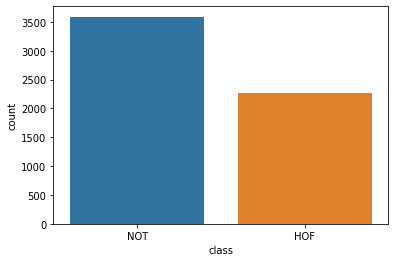

Create Train examples: 100%|██████████| 5852/5852 [00:00<00:00, 6237.93it/s]
Train example 0: 
	Raw text    : watch sports minister kiren rijiju issues statement backing ms dhoni over balidaan badge tell bcci to take up the matter with icc and keep government in the know as nation pride be involve
	Token IDS   : [11493, 2804, 10559, 2910, 7830, 5034, 10937, 1753, 818, 6845, 4073, 7802, 6852, 3698, 3901, 658, 3214, 9058, 6734, 4348, 9, 296, 10528, 810, 7214, 10701, 6734, 11546, 1001, 1369, 6279, 8514, 9586, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	Hate IDS    : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	Label ID    : 0
	Seq length  : 33
Train example 1: 
	Raw text    : no should remember very clearly that just admit to treason
	Token IDS   : [2659, 4502, 971, 3629, 7608, 11543, 11534, 7756, 658, 1996, 0, 0, 0, 0, 0, 0, 0, 0, 0,

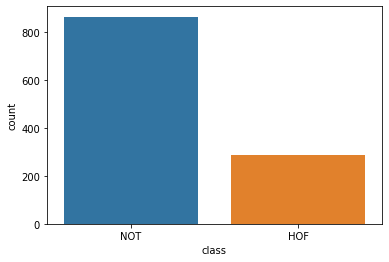

Create Test examples: 100%|██████████| 1153/1153 [00:00<00:00, 6138.26it/s]
Test example 0: 
	Raw text    : west bengal doctor crisis protest doctor agree to meet mamata banerjee in presence of full medium even as be going to go on strike
	Token IDS   : [2491, 5100, 1474, 8233, 7657, 1474, 7572, 658, 6680, 5619, 2466, 10701, 7410, 11229, 10634, 3398, 9437, 1001, 8514, 4490, 658, 2650, 5468, 10875, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	Hate IDS    : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	Label ID    : 0
	Seq length  : 24
Test example 1: 
	Raw text    : million people have be force to leave home read more
	Token IDS   : [9037, 7767, 4315, 8514, 6633, 658, 8787, 9208, 3184, 2591, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [9]:
if not (os.path.exists(f"train_dataset_{data_name}_cached.pt" ) and os.path.exists( f"test_dataset_{data_name}_cached.pt")):
    train_dataset = MyDataset(train_df, MAX_SEQUENCE_LENGTH, dataset_vocab, hate_array, is_balance, dataset_type='Train')
    test_dataset = MyDataset(test_df, MAX_SEQUENCE_LENGTH, dataset_vocab, hate_array, is_balance, dataset_type='Test')
    torch.save(train_dataset, f"train_dataset_{data_name}_cached.pt" )
    torch.save(test_dataset,  f"test_dataset_{data_name}_cached.pt")
else:
    train_dataset = torch.load(f"train_dataset_{data_name}_cached.pt")
    test_dataset = torch.load( f"test_dataset_{data_name}_cached.pt")

In [10]:
class TextCNN(nn.Module):
    def __init__(self, num_filters, num_labels, max_len, vocab_size, embed_dim, pad_idx, dropout_prob, use_hatedict=False, vectors=None):
        super(TextCNN, self).__init__()
        self.max_len = max_len

        self.embed_layer = nn.Embedding.from_pretrained(vectors, padding_idx=pad_idx)
        if vectors is not None:
          self.embed_layer.weight.data = nn.Parameter(vectors, requires_grad=True)
        if use_hatedict:
          self.hate_layer = HateEmbedding(MAX_SEQUENCE_LENGTH)
          embed_dim += 1 
        self.embed_dim = embed_dim

        self.conv1 = nn.Conv1d(1, num_filters, 1 * embed_dim, stride= embed_dim)
        self.conv2 = nn.Conv1d(1, num_filters, 2 * embed_dim, stride= embed_dim)
        self.conv3 = nn.Conv1d(1, num_filters, 3 * embed_dim, stride= embed_dim)

        self.dropout = nn.Dropout(dropout_prob)

        self.fc_layer = nn.Linear(3 * num_filters, num_labels)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_ids, seq_len, hate_ids=None):
        if hate_ids is not None:
          hate_embedded = self.hate_layer(hate_ids)
          word_embedded = self.embed_layer(input_ids)
          input_representation = torch.cat((word_embedded, hate_embedded), -1)
          x = input_representation.view(-1, 1, (self.embed_dim) * self.max_len)
        else:
          x = self.embed_layer(input_ids).view(-1, 1, (self.embed_dim * self.max_len))
        # Convolution
        conv1 = F.relu(self.conv1(x))
        conv2 = F.relu(self.conv2(x))
        conv3 = F.relu(self.conv3(x))

        # Pooling
        pooled_conv1 = F.max_pool1d(conv1, self.max_len - 1 + 1).squeeze(-1)
        pooled_conv2 = F.max_pool1d(conv2, self.max_len - 2 + 1).squeeze(-1)
        pooled_conv3 = F.max_pool1d(conv3, self.max_len - 3 + 1).squeeze(-1)

        x = torch.cat((pooled_conv1, pooled_conv2, pooled_conv3), 1)
        x = self.dropout(x)


        logits = self.fc_layer(x)
        probs = self.softmax(logits)
        return probs

In [14]:
def get_total_time(start_time):
    end = time.time()
    hours, rem = divmod(end - start_time, 3600)
    minutes, seconds = divmod(rem, 60)
    return sum([int(hours*3600), int(minutes*60), int(seconds)])

def caculate_score(actuals, predicts):
    acc_score = metrics.accuracy_score(actuals, predicts)
    f1_macro_score = metrics.f1_score(actuals, predicts, average="macro")
    f1_weighted_score = metrics.f1_score(actuals, predicts, average="weighted")
    report = metrics.classification_report(actuals, predicts, output_dict=True)
    tn, fp, fn, tp = metrics.confusion_matrix(actuals, predicts).ravel()
    f1_0 = round(report['0']['f1-score'], ndigits=2)
    f1_1 = round(report['1']['f1-score'], ndigits=2)
    acc_0 = round(tn/(tn+fp), ndigits=2)
    acc_1 = round(tp/(tp+fn), ndigits=2)
    precision=tp / (tp + fp)
    recall = tp / (tp + fn)
    return acc_score, f1_0, f1_1, acc_0, acc_1, f1_macro_score, precision,recall

def plot_loss(history):
    plt.plot(history['train_loss'])
    plt.plot(history['eval_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Evaluate'], loc='upper left')
    plt.show()

def eval(model, criterion, eval_iter):
    sum_loss = 0
    predicts, actuals = [], []
    model.eval()
    eval_bar = tqdm(eval_iter, desc=f'\tEval',total=len(eval_iter), position=0, leave=0)
    start_time = time.time()
    with torch.no_grad():
      for batch in eval_bar:
        if len(batch) == 3:
          input_ids, label_ids, seq_lens = batch
        else:
          input_ids, label_ids, seq_lens, _ = batch
        if device == 'cuda':
          input_ids = input_ids.cuda()
          label_ids = label_ids.cuda()
          seq_lens = seq_lens.cuda()
        outs = model(input_ids, seq_lens)
        loss = criterion(outs, label_ids)
        sum_loss += loss.item()
        predicts += [y.argmax().item() for y in outs]
        actuals += label_ids.tolist()
    acc_score, f1_0, f1_1, acc_0, acc_1, f1_macro_score,precision,recall = caculate_score(actuals, predicts)
    avg_loss = sum_loss / len(eval_iter)
    reports = metrics.classification_report(actuals, predicts, target_names=list(label_maps.keys()), output_dict=True)
    return avg_loss,  (acc_score, f1_0, f1_1, acc_0, acc_1, f1_macro_score , precision,recall), reports

def train(model, criterion, optimizer, train_iter, eval_iter, scheduler=None):
    history = {'train_loss':[], 'eval_loss':[]}
    best_model = copy.deepcopy(model)
    best_epoch = 0
    min_loss = float('inf')
    counter = 0
    epoch_time = {}
    for epoch in range(num_epochs):
        start = time.time()
        sum_loss = 0
        predicts, actuals = [], []
        model.train()
        train_bar = tqdm(train_iter, desc=f'\tEpoch {epoch}', total=len(train_iter), position=0, leave=0)
        start_time = time.time()
        for batch in train_bar:
          if len(batch) == 3:
            input_ids, label_ids, seq_lens = batch
          else:
            input_ids, label_ids, seq_lens, _ = batch
          if device == 'cuda':
            input_ids = input_ids.cuda()
            label_ids = label_ids.cuda()
            seq_lens = seq_lens.cuda()
          outs = model(input_ids, seq_lens)
          loss = criterion(outs, label_ids)
          loss.backward()
          optimizer.step()
          sum_loss += loss.item()
          predicts += [y.argmax().item() for y in outs]
          actuals += label_ids.tolist()
        train_loss = sum_loss / len(train_iter)
 
        epoch_time[epoch] = get_total_time(start)
        eval_loss, eval_scores, _ = eval(model, criterion, eval_iter)
        if scheduler is not None:
            scheduler.step(eval_loss)
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)
        if eval_loss <= min_loss:
            best_model = copy.deepcopy(model)
            min_loss = eval_loss
            best_epoch = epoch
            counter = 0
        else:
            counter += 1
        if counter >= early_stop:
            break
    plot_loss(history)
    return best_model, best_epoch, epoch_time


In [15]:
# Model Options
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device
embed_dim = 300 # embed dim
dropout_prob = 0.5 # Dropout prob
num_filters = 200 # num filters
pad_idx = 0 # Padding
num_labels = 2 # num labels

# Training Options
num_epochs = 100 # Epoch
num_fold = 5 # Num fold
batch_size = 32
early_stop = 30 # Early Stop
learning_rate = 2e-5 # learning rate
loss_function = nn.CrossEntropyLoss() # Loss Function 

kfold =  StratifiedKFold(n_splits=num_fold, random_state=1, shuffle=True)

Fold-0


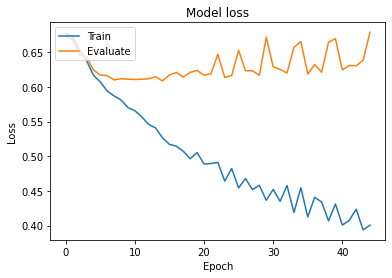


Best Epoch: 14
	AVG Loss: 0.493253; Accurancy: 0.8123; F1_macro: 0.7569;  Precision : 0.6201;Recall: 0.6632
	Class scores:
		NOT: 0.8729216152019003
		HOF: 0.6409395973154361
Fold-1


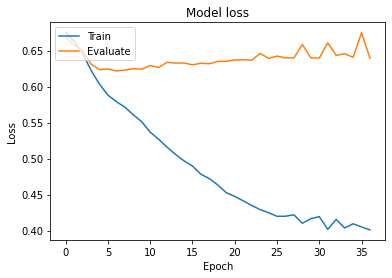


Best Epoch: 6
	AVG Loss: 0.490355; Accurancy: 0.8246; F1_macro: 0.7616;  Precision : 0.6654;Recall: 0.6146
	Class scores:
		NOT: 0.884125144843569
		HOF: 0.6389891696750903
Fold-2


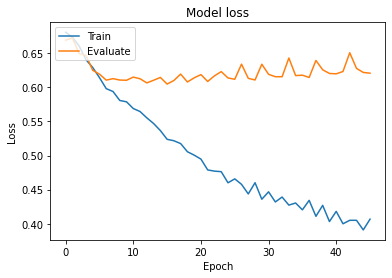


Best Epoch: 15
	AVG Loss: 0.495626; Accurancy: 0.8088; F1_macro: 0.7540;  Precision : 0.6115;Recall: 0.6667
	Class scores:
		NOT: 0.8700834326579262
		HOF: 0.6378737541528239
Fold-3


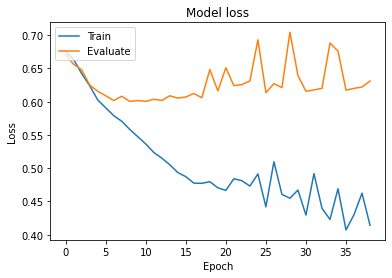


Best Epoch: 8
	AVG Loss: 0.505068; Accurancy: 0.8009; F1_macro: 0.7532;  Precision : 0.5869;Recall: 0.7153
	Class scores:
		NOT: 0.8616697135892748
		HOF: 0.6447574334898278
Fold-4


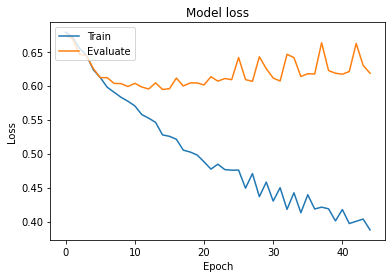


Best Epoch: 14
	AVG Loss: 0.494447; Accurancy: 0.8132; F1_macro: 0.7529;  Precision : 0.6298;Recall: 0.6319
	Class scores:
		NOT: 0.8749266001174398
		HOF: 0.630849220103986
===================================SUMMARY===================================
	AVG Accurancy: 0.8119; AVG F1_macro: 0.7557; Precision: 0.6227; Recall: 0.6583
	AVG Class scores: 
		NOT: 0.8727
		HOF: 0.6387
Accuracy for label 0: 0.8640
F1 for label 0: 0.8700
Accuracy for label 1: 0.6580
F1 for label 1: 0.6380
Macro F1 Score: 0.7557
Precision: 0.6227
Recall: 0.6583
Acc Score: 0.8119
------------------------------
Total 5-Fold Time: [58, 48, 59, 50, 58]
Total 5-Fold Time: 273
Avg Fold Time: 54.6
Avg Epoch Time 1.0
Num of Epoches: [45, 37, 46, 39, 45]


In [17]:
data_idxs = list(range(train_dataset.__len__()))
data_labels = [train_dataset.examples[i][1] for i in data_idxs]
label_maps = {"NOT": 0, "HOF":1}
avg_scores = {'f1_0': [],'f1_1':[],'acc_0': [],'acc_1': [], 'macro_f1': [], 'macro_acc': [],'precision':[],'recall': [], 'acc': [],'labels': {k:[] for k in label_maps.keys()}}
criterion = nn.CrossEntropyLoss()
total_time = []
total_epoch = []
epoches = []
for idx, (train_index, test_index) in enumerate(kfold.split(data_idxs, data_labels)):
    start = time.time()
    model = TextCNN(num_filters, num_labels, MAX_SEQUENCE_LENGTH,embedded_matrix.shape[0], embed_dim, pad_idx, dropout_prob, vectors=embedded_matrix)
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-5)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    eval_subsampler = torch.utils.data.SubsetRandomSampler(test_index)
    train_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler, collate_fn=MyDataset.collate_fn)
    eval_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=eval_subsampler, collate_fn=MyDataset.collate_fn)
    logger.info(f"Fold-{idx}")
    best_model, best_epoch, epoch_time = train(model, criterion, optimizer, train_iter, eval_iter)
    logger.info(f"\nBest Epoch: {best_epoch}")
    epoches.append(len(list(epoch_time.values())))
    total_epoch.append(round(np.mean(list(epoch_time.values()))))
    test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=MyDataset.collate_fn)
    loss, scores, reports = eval(best_model, criterion, test_iter)
    logger.info(f"\tAVG Loss: {loss:.6f}; Accurancy: {scores[0]:.4f}; F1_macro: {scores[5]:.4f};  Precision : {scores[6]:.4f};Recall: {scores[7]:.4f}")
    logger.info(f"\tClass scores:")
    avg_scores['acc'].append(scores[0])
    avg_scores['f1_0'].append(scores[1])
    avg_scores['f1_1'].append(scores[2])
    avg_scores['acc_0'].append(scores[3])
    avg_scores['acc_1'].append(scores[4])
    avg_scores['macro_f1'].append(scores[5])
    avg_scores['precision'].append(scores[6])
    avg_scores['recall'].append(scores[7])
    for label in label_maps.keys():
        avg_scores['labels'][label].append(reports[label]['f1-score'])
        logger.info(f"\t\t{label}: {reports[label]['f1-score']}")
    total_time.append(get_total_time(start))
logger.info(f"{'='*35}SUMMARY{'='*35}")
logger.info(f"\tAVG Accurancy: {(sum(avg_scores['acc'])/num_fold):.4f}; AVG F1_macro: {(sum(avg_scores['macro_f1'])/num_fold):.4f}; Precision: {(sum(avg_scores['precision'])/num_fold):.4f}; Recall: {(sum(avg_scores['recall'])/num_fold):.4f}")
logger.info("\tAVG Class scores: ")
for label in label_maps.keys():
    logger.info(f"\t\t{label}: {(sum(avg_scores['labels'][label])/num_fold):.4f}")
logger.info(f"Accuracy for label 0: {(sum(avg_scores['acc_0'])/num_fold):.4f}")
logger.info(f"F1 for label 0: {(sum(avg_scores['f1_0'])/num_fold):.4f}")
logger.info(f"Accuracy for label 1: {(sum(avg_scores['acc_1'])/num_fold):.4f}")
logger.info(f"F1 for label 1: {(sum(avg_scores['f1_1'])/num_fold):.4f}")
logger.info(f"Macro F1 Score: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info(f"Precision: {(sum(avg_scores['precision'])/num_fold):.4f}")
logger.info(f"Recall: {(sum(avg_scores['recall'])/num_fold):.4f}")
logger.info(f"Acc Score: {(sum(avg_scores['acc'])/num_fold):.4f}")
logger.info("-"*30)
logger.info(f'Total 5-Fold Time: {total_time}')
logger.info(f'Total 5-Fold Time: {np.sum(total_time)}')
logger.info(f'Avg Fold Time: {np.mean(total_time)}')
logger.info(f'Avg Epoch Time {np.mean(total_epoch)}')
logger.info(f'Num of Epoches: {epoches}')